# Vowel Detection Neural Network

## Introduction
1. Train a Feedforward Neural Networks to recognize a vowel based on Linear Predictive Coding (LPC) Coefficients (`LPC14`)
2. Dataset Pairs `<LPC14 Coefficients of vowels, 1 Hot Encoding of Vowels>`
3. Change the number of hidden Layer Neural Network neurons to see which architecture best minimizes loss

### Vowel Classification
| Backness         | Vowel Transcription | [IPA](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/International_Phonetic_Alphabet&ved=2ahUKEwitgoiUvPWEAxUhGDQIHR2IDMoQFnoECBQQAQ&usg=AOvVaw3T7iQw-yz0dlfkE0oDRulL) | One Hot Encoding Index |
| ---------------- | ------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------- |
| Front            | iy                  | `i`                                                                                                                                                                                                                     | 1                      |
| Front            | ih                  | `ɪ`                                                                                                                                                                                                                     | 2                      |
| Front            | ey                  | `ɛ`                                                                                                                                                                                                                     | 3                      |
| Front            | eh                  | `æ`                                                                                                                                                                                                                     | 4                      |
| Front (diphtong) | ae                  | `ei`                                                                                                                                                                                                                    | 5                      |
| Back             | uw                  | `u`                                                                                                                                                                                                                     | 6                      |
| Central          | uh                  | `ə`                                                                                                                                                                                                                     | 7                      |
| Back             | ow                  | `o`                                                                                                                                                                                                                     | 8                      |
| Back             | ao                  | `ɔ`                                                                                                                                                                                                                     | 9                      |
| Back             | aa                  | `ɑ`                                                                                                                                                                                                                     | 10                     |

## Step 0) Import Libraries and Dataset Constants

In [28]:
# PyTorch for feedforward NN architecture library
import torch
import torch.optim as optim

# Science Python library for loading matlab `.mat` files containing training data `ground_truth.mat` and `training_lpc.mat` 
import scipy.io

# Plotting libraries for analyzing the loss and accuracy of the model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# For pathing
import os
import glob

# For data management
from collections import defaultdict
import copy
import sys

## Step 1) Import Training Data

In [29]:
# Declare LPC or MFCC Mode
PARAMETERIZATION_TYPE = "MFCC"
if PARAMETERIZATION_TYPE != "LPC" and PARAMETERIZATION_TYPE != "MFCC":
    raise(ValueError(f"PARAMETERIZATION_TYPE is {PARAMETERIZATION_TYPE}, but must be 'LPC' or 'MFCC."))

NUM_COEFFICIENTS = 14
VOWEL_LIST = ["iy", "ih", "eh", "ae", "ey", "uw", "uh", "ow", "ao", "aa"]

In [30]:
# Load in inputs and ouput data from Matlab .mat files
def load_dataset(mat_file_path: str, num_coefficient: int, num_labels:int, input_key: str, label_key: str) -> tuple[np.ndarray, np.ndarray]:
    # Step 1) Load in the `.mat` extension as a list
    data_as_arr = scipy.io.loadmat(mat_file_path)
    inputs_as_arr = data_as_arr[input_key]
    outputs_as_arr = data_as_arr[label_key]

    # Step 2) Reshape as an n by m 2D array where n=num_samples and m=num_coefficient
    input_as_nd_arr = torch.tensor(np.array(inputs_as_arr).reshape(-1, num_coefficient), dtype=torch.float)
    output_as_nd_arr = torch.tensor(np.array(outputs_as_arr).reshape(-1, num_labels), dtype=torch.float)

    print("TODO DEBUG REMOVE: ", input_as_nd_arr.shape, outputs_as_arr.shape)
    return input_as_nd_arr, output_as_nd_arr

In [31]:
COEFFICIENT_DATASET_KEY = "wav_parameterization"
ENCODING_DATASET_KEY = "one_hot_encoding_labels"

In [32]:
# Import Training Dataset
TRAINING_DATASET_FOLDER = "../Matlab/data/InClass"
TRAINING_DATASET_INPUTS = os.path.join(
    TRAINING_DATASET_FOLDER, f"{PARAMETERIZATION_TYPE}*.mat"
)

training_path = glob.glob(TRAINING_DATASET_INPUTS)[0]

training_dataset = load_dataset(
    mat_file_path=training_path,
    num_coefficient=NUM_COEFFICIENTS,
    num_labels=len(VOWEL_LIST),
    input_key=COEFFICIENT_DATASET_KEY,
    label_key=ENCODING_DATASET_KEY
)

TODO DEBUG REMOVE:  torch.Size([236, 14]) (236, 10)


In [33]:
TEST_DATASET_PATH = "../Matlab/data/Hillenbrand/"
test_types = ["man", "woman", "boy", "girl"]

testing_data: dict[str, tuple[np.ndarray, np.ndarray]] = {
    speaker_type: load_dataset(
        mat_file_path=glob.glob(
            os.path.join(TEST_DATASET_PATH,
                         speaker_type,
                         f"{PARAMETERIZATION_TYPE}*.mat"
                         ))[0],
        num_coefficient=NUM_COEFFICIENTS,
        num_labels=len(VOWEL_LIST),
        input_key=COEFFICIENT_DATASET_KEY,
        label_key=ENCODING_DATASET_KEY
    )
    for speaker_type in test_types
}

TODO DEBUG REMOVE:  torch.Size([90, 14]) (90, 10)
TODO DEBUG REMOVE:  torch.Size([100, 14]) (100, 10)
TODO DEBUG REMOVE:  torch.Size([90, 14]) (90, 10)
TODO DEBUG REMOVE:  torch.Size([90, 14]) (90, 10)


## Step 2) Generate Model Architecture
- As we are trying to use different model architecture, we will use a function to encapsulate the model parameters

### Step 2a) Create Vowel Classifier Architecutre
- Use a function to create the Feedforward NN architecture and its respective Stochastic Gradient Descent optimizer


Note: Model Has the following architecture:

| Layer # | Description                                          | Size                                                                   |
| ------- | ---------------------------------------------------- | ---------------------------------------------------------------------- |
| 1       | Input Neurons containing the LPC Values              | 14 (1 per LPC coefficient)                                             |
| 2       | Hidden Layer to convexify the classification problem | 1-5 (independent variable to see which architecture performs the best) |
| 3       | One Hot Encoding of the vowel                        | 10 (ten vowels)                                                        |

```
  Layer 1            Layer 2         Layer 3
    I1                                 
    I2                                 O1
    I3                                 O2
    I4                                 O3
    ...                X               ...
    I11                                O10
    I13
    I14  
```                               

In [34]:
def create_lpc_vowel_classifier(
    NUM_LPC: int,
    HIDDEN_LAYER_SIZE: int,
    ONE_HOT_ENCODING_SIZE: int,
    LEARNING_RATE: float
) -> tuple[torch.nn.Module, torch.optim.Optimizer]:
    """
    Creates a Feedforward Neural Network and an optimizer to improve the loss of the model.

    ## Parameters
    INPUT_SIZE: int
        Number of inputs to the NN (in our case, the number of LPCs)

    HIDDEN_LAYER_SIZE: int
        Number of inputs from Input to the Hidden Layer (variable for experimentation purposes)

    ONE_HOT_ENCODING_SIZE: int
        The final output layer's dimensions for the One Hot Encoding of the vowel

    LEARNING_RATE: float
        Learning Rate for the Stochastic Gradient Descent Optimizer    

    ## Returns
    model: torch.nn.Module
        feedforward NN with randomized weights and biases whose architecture is based on the function parameters
    optimzer: torch.optim.Optimizer
        Stochastic Gradient Descent object that uses the gradients calculated 
        by a `loss_function` to update the `model`'s weights and biases
    """

    # Step 1) Create the model architecture
    model = torch.nn.Sequential(
        # Layer 1
        torch.nn.Linear(NUM_LPC, HIDDEN_LAYER_SIZE),
        torch.nn.Sigmoid(),

        # Layer 2
        torch.nn.Linear(HIDDEN_LAYER_SIZE, ONE_HOT_ENCODING_SIZE),
        torch.nn.Softmax(dim=1)
    )
    
    # Step 2) Create the Stochastic Gradient Descent object
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    return model, optimizer

## Step 2B) Train Classifier
- Next we will have a function responsible for the training iterations of the `optimizer` and `model` we create from `create_lpc_vowel_classifier`

### Loss Function Type
- The `loss_function` sums the Mean Squared Error of `model prediction` vs `ground truth` 
- The loss is summed over all 218 samples of vowels using the `reduction=sum` flag

## Step 3) Analyze Data Visually
1. Use a plot for seeing the loss of the values over time
2. Visualize the prediction of the model using a 2D color plot
3. Overlay the loss values of different trials of training

In [35]:
def plot_all(
    train_history: list[list],
    test_history: list[list],
    num_trials: int,
    y_label: str,
    unit: int,
    main_title: str = None,
) -> None:
    """
    Plots the loss of the first `num_trials` training sessions (A-E) of the Vowel Classifier for NN with 1 - 5 hidden neurons.

    Note: In this context, training session means an entire re-initialization of weights and biases of a fresh Neural Network
    
    ## Parameters
    loss_history: np.ndarray
        Shape: (Number of neurons in the hidden layer, number of training sessions, NUM_EPOCHS//CLOCK_RATE)
        A 3D numpy array where the x index is the number of hidden neurons and the y is the training session number, 
        and z is the recorded loss at every `CLOCK_RATE`th iteration.
    
    num_trials: int
        Plots the entire loss history for the first `num_trials` for each of the neural network architectures
    
    unit: int
        The number of training iterations that elapse between each Z index of loss_history(_, _, Z) 
        if unit = 1,000 iterations
        ex: loss_history(0, 0, 0) represents a neural network with 1 hidden neuron, during training session A, and the loss after the 0th epoch of training
            loss_history(0, 0, 1) represents the same neural network and training session as above and the loss after the `1,000`th epoch of training
    """

    plt.rcParams['figure.figsize'] = (15, 30)
    fig, axes = plt.subplots(nrows=num_trials, ncols=1)
    plt.subplots_adjust(hspace=0.6, wspace=0.6, top=0.95)

    if(main_title != None):
        fig.suptitle(main_title, fontsize=30)

    # The first axis in the 3D array is the number of hidden neurons used in the single vowel classification
    for trial_idx in range(num_trials):
        # Title the graph: ex: Loss of 1 hidden Neurons for Trial A
        subplot_title = f"Trial {chr(ord('A') + trial_idx)}"

        # Format Titles
        cur_subplot = axes[trial_idx]
        cur_subplot.set_title(subplot_title)
        cur_subplot.set_ylabel(y_label)
        cur_subplot.set_xlabel(f"1 unit = {unit} iterations")
        cur_subplot.yaxis.grid(True)

        # Format Boxplots for Front vs. Back Vowels
        cur_subplot.plot(train_history[trial_idx], color='blue', label=f"Training {y_label}")
        cur_subplot.plot(test_history[trial_idx], color='red', label=f"Testing {y_label}")

        cur_subplot.legend()

In [36]:
def calculate_cohens_d(dataset1: np.array, dataset2: np.array) -> tuple[np.float32, str]:
    """
    Compare the effect size of dataset1's and dataset2's LPC_X where
    X is an arbitrary LPC Coefficient

    ## Parameters
    lpc_x_dataset1 : np.array
        The Xth LPC coefficients for every sample in dataset 1
            ex: LPC 12 for all `front vowels`
    
    lpc_x_dataset2 : np.array
        The Xth LPC coefficients for every sample in dataset 2
            ex: LPC 12 for all `front vowels`
    
    Note: Both datasets should be have the same LPC index

    ## Returns
    cohens_d : np.float64
        Cohen's D or Effect Size of LPC Index X with respect to dataset 1 and dataset 2
            ex: How likely the difference between LPC X in dataset 1 and dataset 2 
                is to be noticeable in an experiment/real life scenario

    label: str
        Returns whether the effect size is Small, Medium, or Large
    """

    assert len(dataset1) > 1, "dataset1 must have more than 1 number" 
    assert len(dataset1) > 1, "dataset2 must have more than 1 number" 

    # Step 1) Numerator = Mean Difference
    mean_difference = np.mean(dataset1) - np.mean(dataset2)
    
    # Step 2) Get the total variance of both datasets
    total_variance = np.std(dataset1)**2 + np.std(dataset2)**2

    # Step 3) Normalize the Variance
    normalized_variance = np.sqrt(total_variance) / 2

    # Step 4) Calculate effect size
    cohens_d = mean_difference / normalized_variance

    # Step 5) Get the label according to Cohen's D
    label = ""
    if(abs(cohens_d) >= 0.8):
        label = "Large"
    elif(abs(cohens_d) >= 0.5):
        label = "Medium"
    else:
        label = "Small"
        
    return cohens_d, label

## Step 4) Linking It All Together

### Step 4A) Declare the constants of the models

In [37]:
# Number of hidden neurons
# HIDDEN_LAYER_SIZES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
HIDDEN_LAYER_SIZES = [10]

# Number of trials for testing a single Hidden layer Architecture
NUM_TRIALS = 10

# Record every `Clock_Rate`th sample
CLOCK_RATE = 1000

In [38]:
# Model Hyperparameters
LEARNING_RATE = 0.1
NUM_EPOCHS = 100000

# Model Architecture
INPUT_SIZE = NUM_COEFFICIENTS
OUTPUT_SIZE = len(VOWEL_LIST)

### Step 4B) Declare the data structures which will hold the loss histories and calculate the loss

In [39]:
# Store each of the losses as a dictionary of Hidden LayersSize to an array of losses
# Each index in the array of losses is an entire loss history for training
training_loss_histories = defaultdict(list)
training_acc_histories = defaultdict(list)


test_loss_histories = {demographic: defaultdict(list) for demographic in test_types}
test_acc_histories = {demographic: defaultdict(list) for demographic in test_types}

# Use normalized Cross Entropy Loss for classification problem (softmax implicitly applied)
loss_function = torch.nn.MSELoss(reduction='sum')
# loss_function = torch.nn.CrossEntropyLoss()

In [40]:
# Unpack Training and Testing Data
training_inputs, training_ground_truth = training_dataset

In [41]:
print_loss_flag = True

In [42]:
# Keep the best model for each demographic based on the testing data
# best_model = None
# lowest_loss = sys.float_info.max

### Step 4C) Train each model architecture over `NUM_TRIALS` trials

In [43]:
the_last_model = None
for num_hidden_neurons in HIDDEN_LAYER_SIZES:
    # Change the number of hidden neurons in the hidden layer

    for trial_num in range(NUM_TRIALS):
        # Step 1) Create Model
        model, optimizer = create_lpc_vowel_classifier(
            NUM_LPC=INPUT_SIZE,
            HIDDEN_LAYER_SIZE=num_hidden_neurons,
            ONE_HOT_ENCODING_SIZE=OUTPUT_SIZE,
            LEARNING_RATE=LEARNING_RATE
        )

        # Step 2) Train the model
        model.train()
        training_loss_histories[num_hidden_neurons].append([])
        training_acc_histories[num_hidden_neurons].append([])
        for loss_history, acc_history in zip(test_loss_histories.values(), test_acc_histories.values()):
            loss_history[num_hidden_neurons].append([])
            acc_history[num_hidden_neurons].append([])

        # Step 2) Train Model
        for i in range(NUM_EPOCHS):
            optimizer.zero_grad()
            # Step 2a) Forward Propogate all samples of `training_data`
            vowel_prediction = model(training_inputs)

            # Step 2b) Calculate the loss
            training_loss = loss_function(
                vowel_prediction, training_ground_truth)

            # Step 3) Record loss history
            if print_loss_flag and i % CLOCK_RATE == 0:
                # Step 3) Record Training Loss

                train_accuracy = float((torch.argmax(vowel_prediction, 1) == torch.argmax(
                    training_ground_truth, 1)).float().mean())
                # print(training_loss.item())
                training_loss_histories[num_hidden_neurons][trial_num].append(
                    training_loss.item())
                training_acc_histories[num_hidden_neurons][trial_num].append(
                    train_accuracy)

                # Step 4) Record Testing Loss
                model.eval()
                for demographic in test_types:
                    test_inputs, test_labels = testing_data[demographic]
                    test_prediction = model(test_inputs)

                    test_loss = loss_function(test_prediction, test_labels)
                    test_accuracy = float(
                        (torch.argmax(test_prediction, 1) == torch.argmax(test_labels, 1)).float().mean())

                    test_loss_histories[demographic][num_hidden_neurons][trial_num].append(
                        test_loss.item())
                    test_acc_histories[demographic][num_hidden_neurons][trial_num].append(
                        test_accuracy)                    

                model.train()

            # Step 2c) Calculate the new gradient (note: we need zero_grad() to clear the previous training iterations gradient)
            training_loss.backward()

            # Step 2d) Apply the gradient with the learning rate to updated the weighs and biases
            optimizer.step()

            
        the_last_model = copy.deepcopy(model)

## Step 5) Visualizing the Data
A) Plot Losses
B) Last Loss per architecture
C) Visualize Classification

### Step 5A) Plot Losses
- Plot the losses for 5 trials of each neural network architecture

In [44]:
unit = NUM_EPOCHS//CLOCK_RATE
print(unit)

100


In [45]:
print(len(training_loss_histories[10][0]))

100


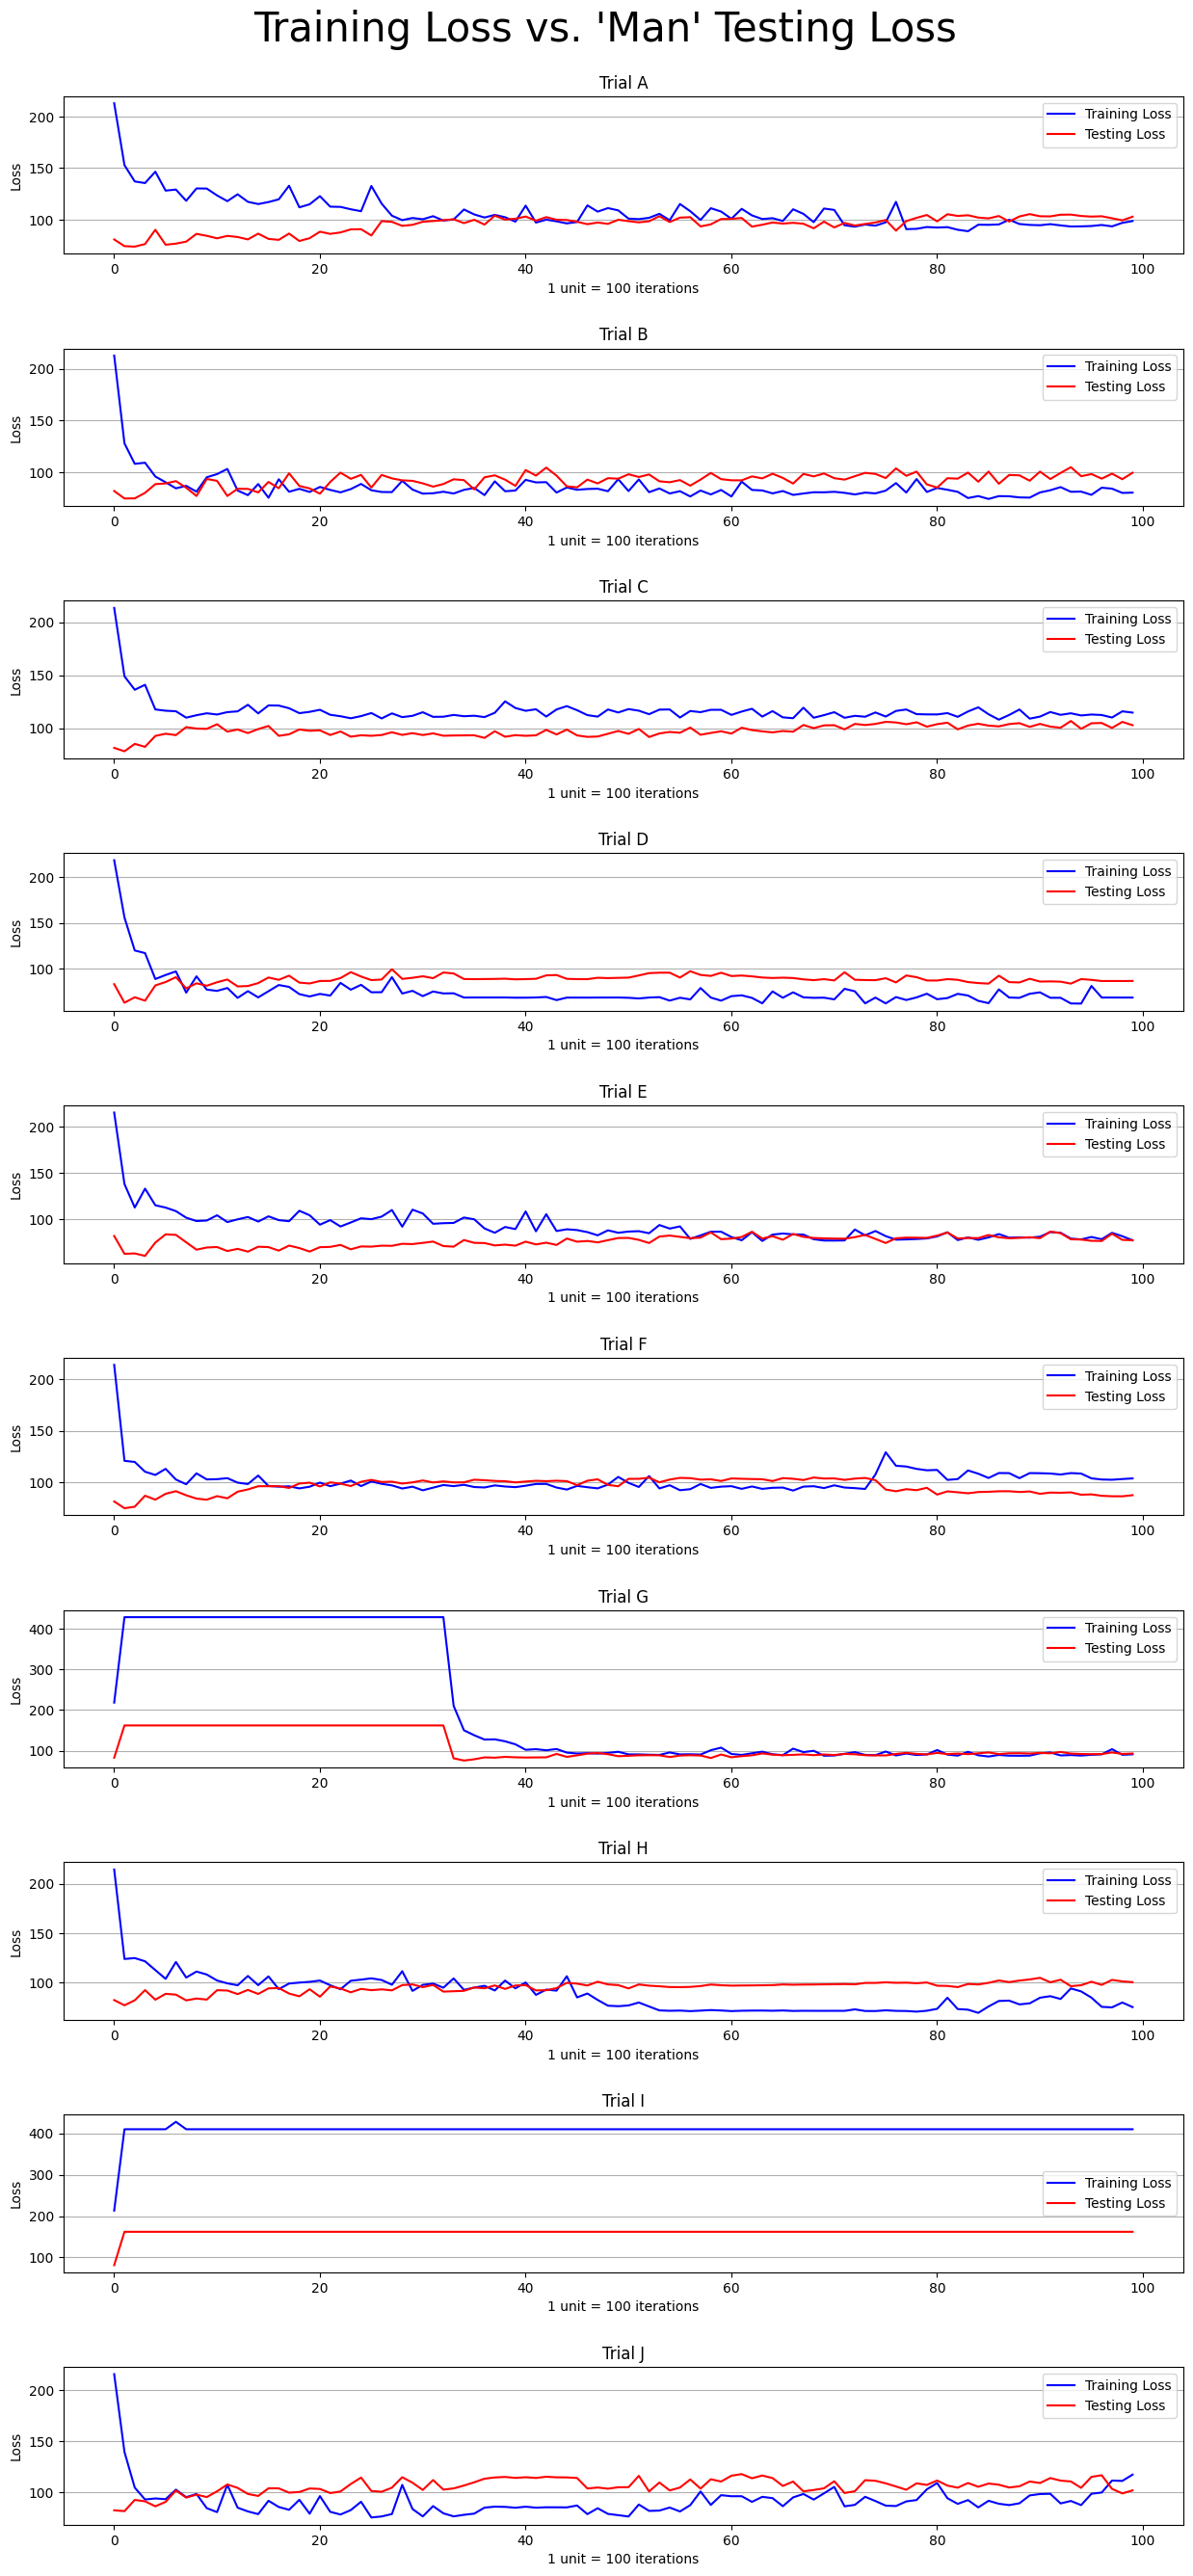

In [46]:
plot_all(
    train_history= training_loss_histories[10],
    test_history=test_loss_histories["man"][10],
    y_label= "Loss",
    num_trials=NUM_TRIALS,
    unit=unit,
    main_title="Training Loss vs. 'Man' Testing Loss"
)

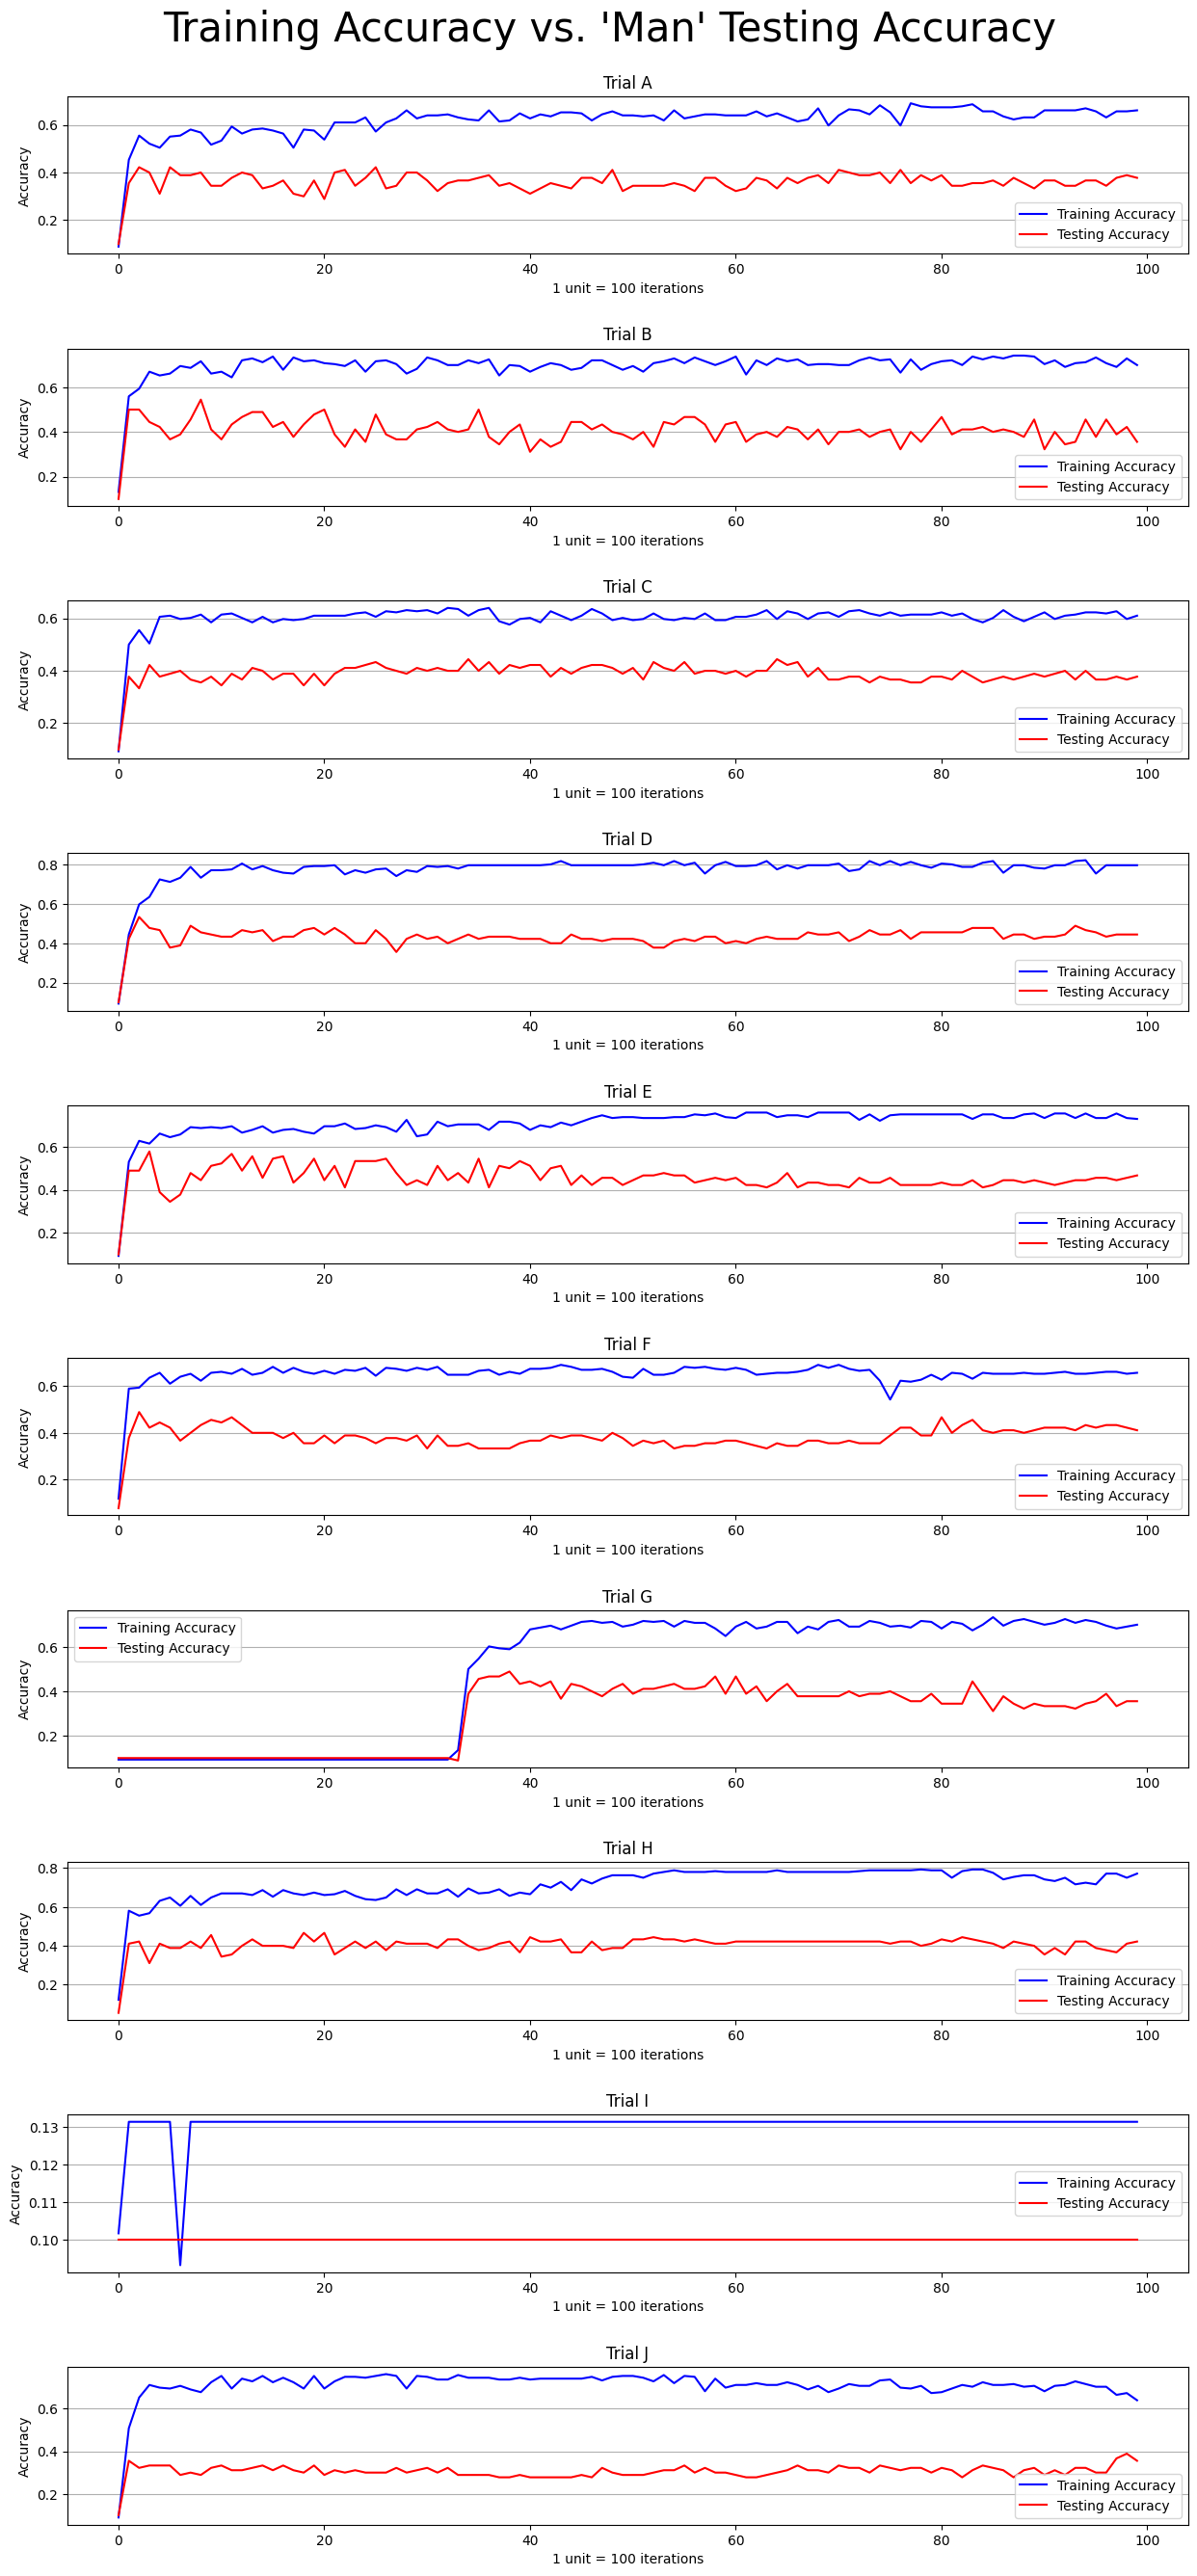

In [47]:
plot_all(
    train_history= training_acc_histories[10],
    test_history=test_acc_histories["man"][10],
    y_label= "Accuracy",
    num_trials=NUM_TRIALS,
    unit=unit,
    main_title="Training Accuracy vs. 'Man' Testing Accuracy"
)

### Step 5B) Last Loss per architecture
- Find how the median loss varies vs the number of neurons in the hidden layer

In [48]:
# median_losses = []

# for hidden_neuron_idx in range(len(HIDDEN_LAYER_SIZES)):
#     # Step 1) Get the last loss for all iterations corresponding to `hidden_neuron_idx` 
#     last_losses: np.array = all_training_loss_histories[hidden_neuron_idx][:][-1]

#     # Step 2) Take the median of the last lost (approximate how well the model performed)
#     last_loss_median = np.median(last_losses)

#     # Step 3) Append to array
#     median_losses.append(last_loss_median)

#     print(f"Median Losses: {median_losses[-1]}")

# plt.plot(HIDDEN_LAYER_SIZES, median_losses)
# plt.title("Median Loss vs. Number of Hidden Neuron")
# plt.ylabel("Median Loss")
# plt.xlabel("Number of Hidden Neurons")

### Step 5C) Visualize Classification

Confusion Matrix

In [84]:
def plot_confusion(model: torch.nn.Module, inputs: torch.tensor, ground_truth: np.ndarray, title: str, string_labels: list) -> None:
    model.eval()
    with torch.no_grad():
        prediction = model(inputs)
        predicted_label_idxs = torch.argmax(prediction, dim=1).numpy()
        predicted_label_str = [VOWEL_LIST[vowel_idx]
                               for vowel_idx in predicted_label_idxs]

    ground_truth_str = [VOWEL_LIST[vowel_idx]
                        for vowel_idx in torch.argmax(ground_truth, dim=1).numpy()]

    confusion_mat = confusion_matrix(
        ground_truth_str, predicted_label_str, labels=string_labels)
    print(confusion_mat)
    plt.figure(figsize=(12, 7))
    plt.title(title)
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.xticks(ticks=range(len(string_labels)), labels=string_labels)
    plt.yticks(ticks=range(len(string_labels)), labels=string_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.colorbar()
    plt.show()

[[25  1  0  1  1  1  0  0  1  1]
 [ 0 22  0  0  0  0  0  0  0  0]
 [ 2 18  3  1  1  1  1  1  2  0]
 [ 1  1  0 20  0  0  0  0  0  0]
 [ 0  0  0  0 21  0  0  0  0  1]
 [ 0  0  0  0  0 21  0  0  0  0]
 [ 1  0  0  0  0  2 16  2  1  0]
 [ 1  0  0  0  0  1  1 15  4  0]
 [ 0  1  0  0  0  0  0  2 19  0]
 [ 0  0  0  0  1  0  0  1  8 12]]


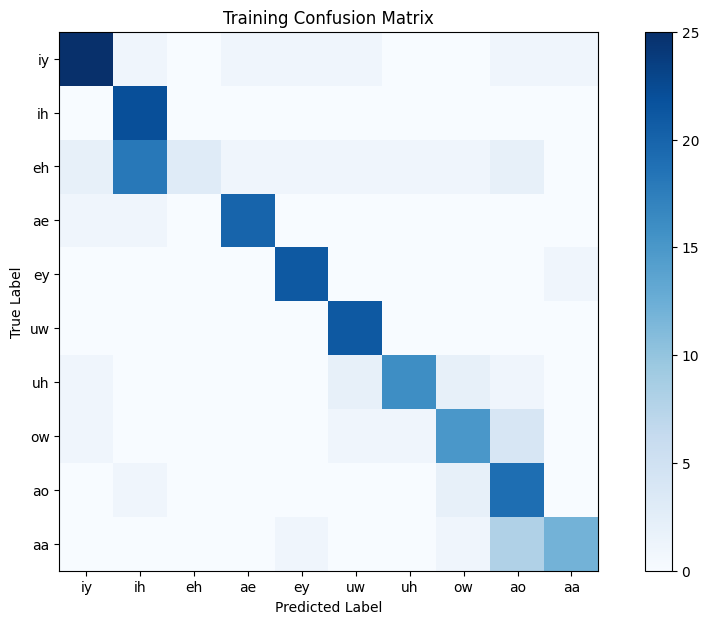

In [85]:
plot_confusion(the_last_model, training_inputs, training_ground_truth, "Training Confusion Matrix", VOWEL_LIST)

[[0 9 0 0 0 0 0 0 0 0]
 [0 7 0 2 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 0 0]
 [0 0 0 6 1 0 0 0 1 1]
 [0 0 0 7 1 0 0 0 1 0]
 [0 0 0 0 0 3 5 1 0 0]
 [0 0 0 0 2 0 1 0 6 0]
 [0 1 0 0 0 0 1 7 0 0]
 [0 0 1 0 1 0 3 0 4 0]
 [0 0 0 0 5 0 0 0 4 0]]


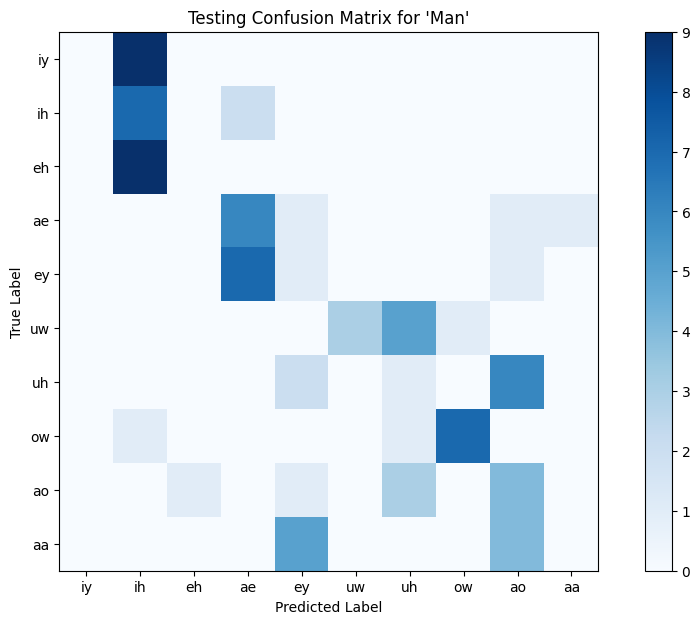

[[ 1  9  0  0  0  0  0  0  0  0]
 [ 0  4  0  6  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0  1  6  3  0  0  0  0  0]
 [ 0  0  2  1  6  0  0  0  1  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  1  0  7  0  0  0  2  0]
 [ 0  0  0  0  0  0  2  8  0  0]
 [ 0  0  0  0  9  0  0  0  1  0]
 [ 0  0  0  0 10  0  0  0  0  0]]


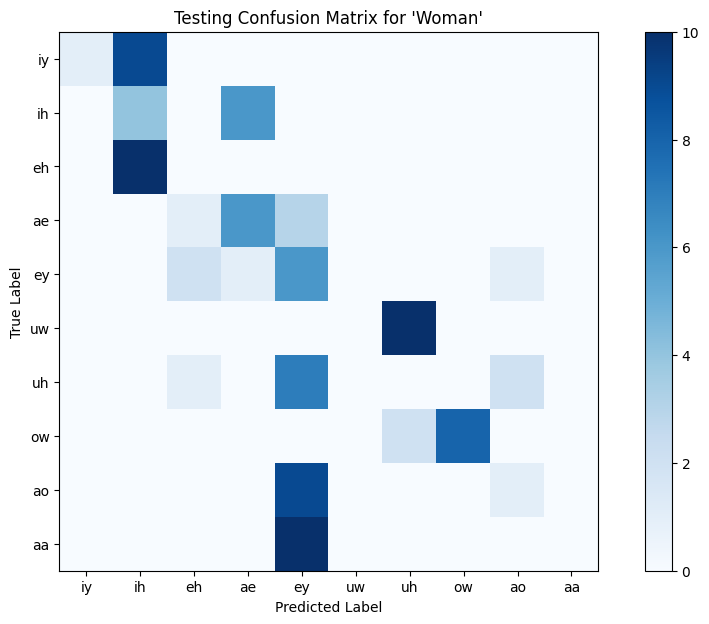

[[1 7 0 1 0 0 0 0 0 0]
 [0 6 1 2 0 0 0 0 0 0]
 [0 8 0 1 0 0 0 0 0 0]
 [0 1 0 7 1 0 0 0 0 0]
 [0 0 0 5 4 0 0 0 0 0]
 [0 1 0 0 1 1 6 0 0 0]
 [0 0 0 1 6 0 0 0 2 0]
 [0 0 0 0 0 0 0 7 2 0]
 [0 0 0 0 6 0 1 0 2 0]
 [0 0 0 0 8 0 0 0 1 0]]


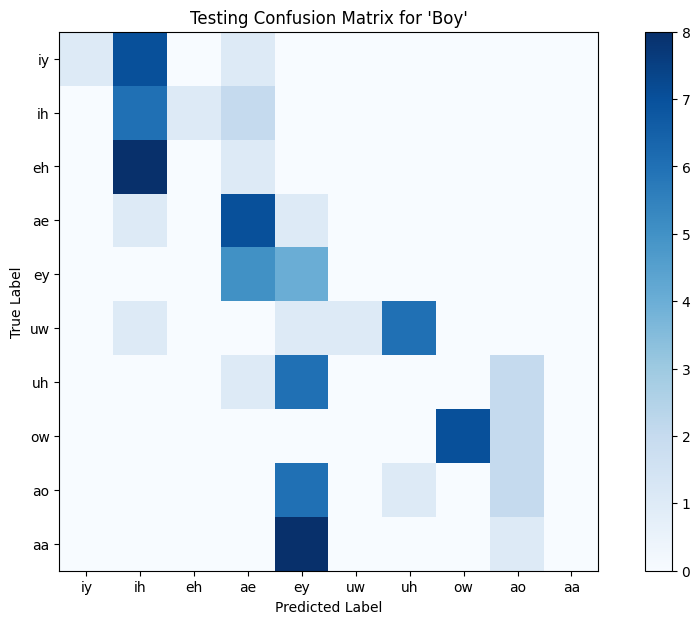

[[3 6 0 0 0 0 0 0 0 0]
 [0 8 1 0 0 0 0 0 0 0]
 [0 7 0 2 0 0 0 0 0 0]
 [0 1 0 4 3 0 0 0 1 0]
 [0 0 0 3 5 0 0 0 1 0]
 [0 0 0 0 0 0 8 0 1 0]
 [0 0 0 1 5 0 0 0 2 1]
 [0 0 0 0 0 0 0 8 1 0]
 [0 0 0 0 9 0 0 0 0 0]
 [0 0 0 0 8 0 0 0 1 0]]


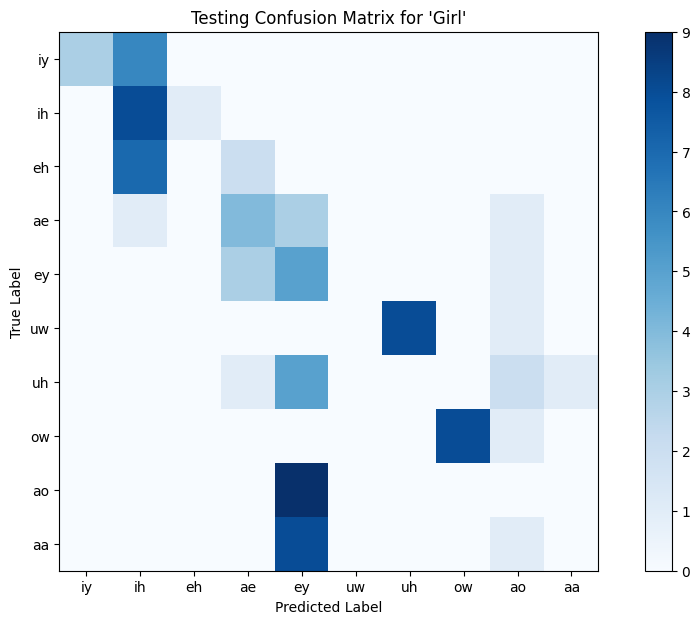

In [87]:
for demographic in test_types:
    test_inputs, test_labels = testing_data[demographic]
    plot_confusion(the_last_model, test_inputs, test_labels, f"Testing Confusion Matrix for '{demographic.capitalize()}'", VOWEL_LIST)

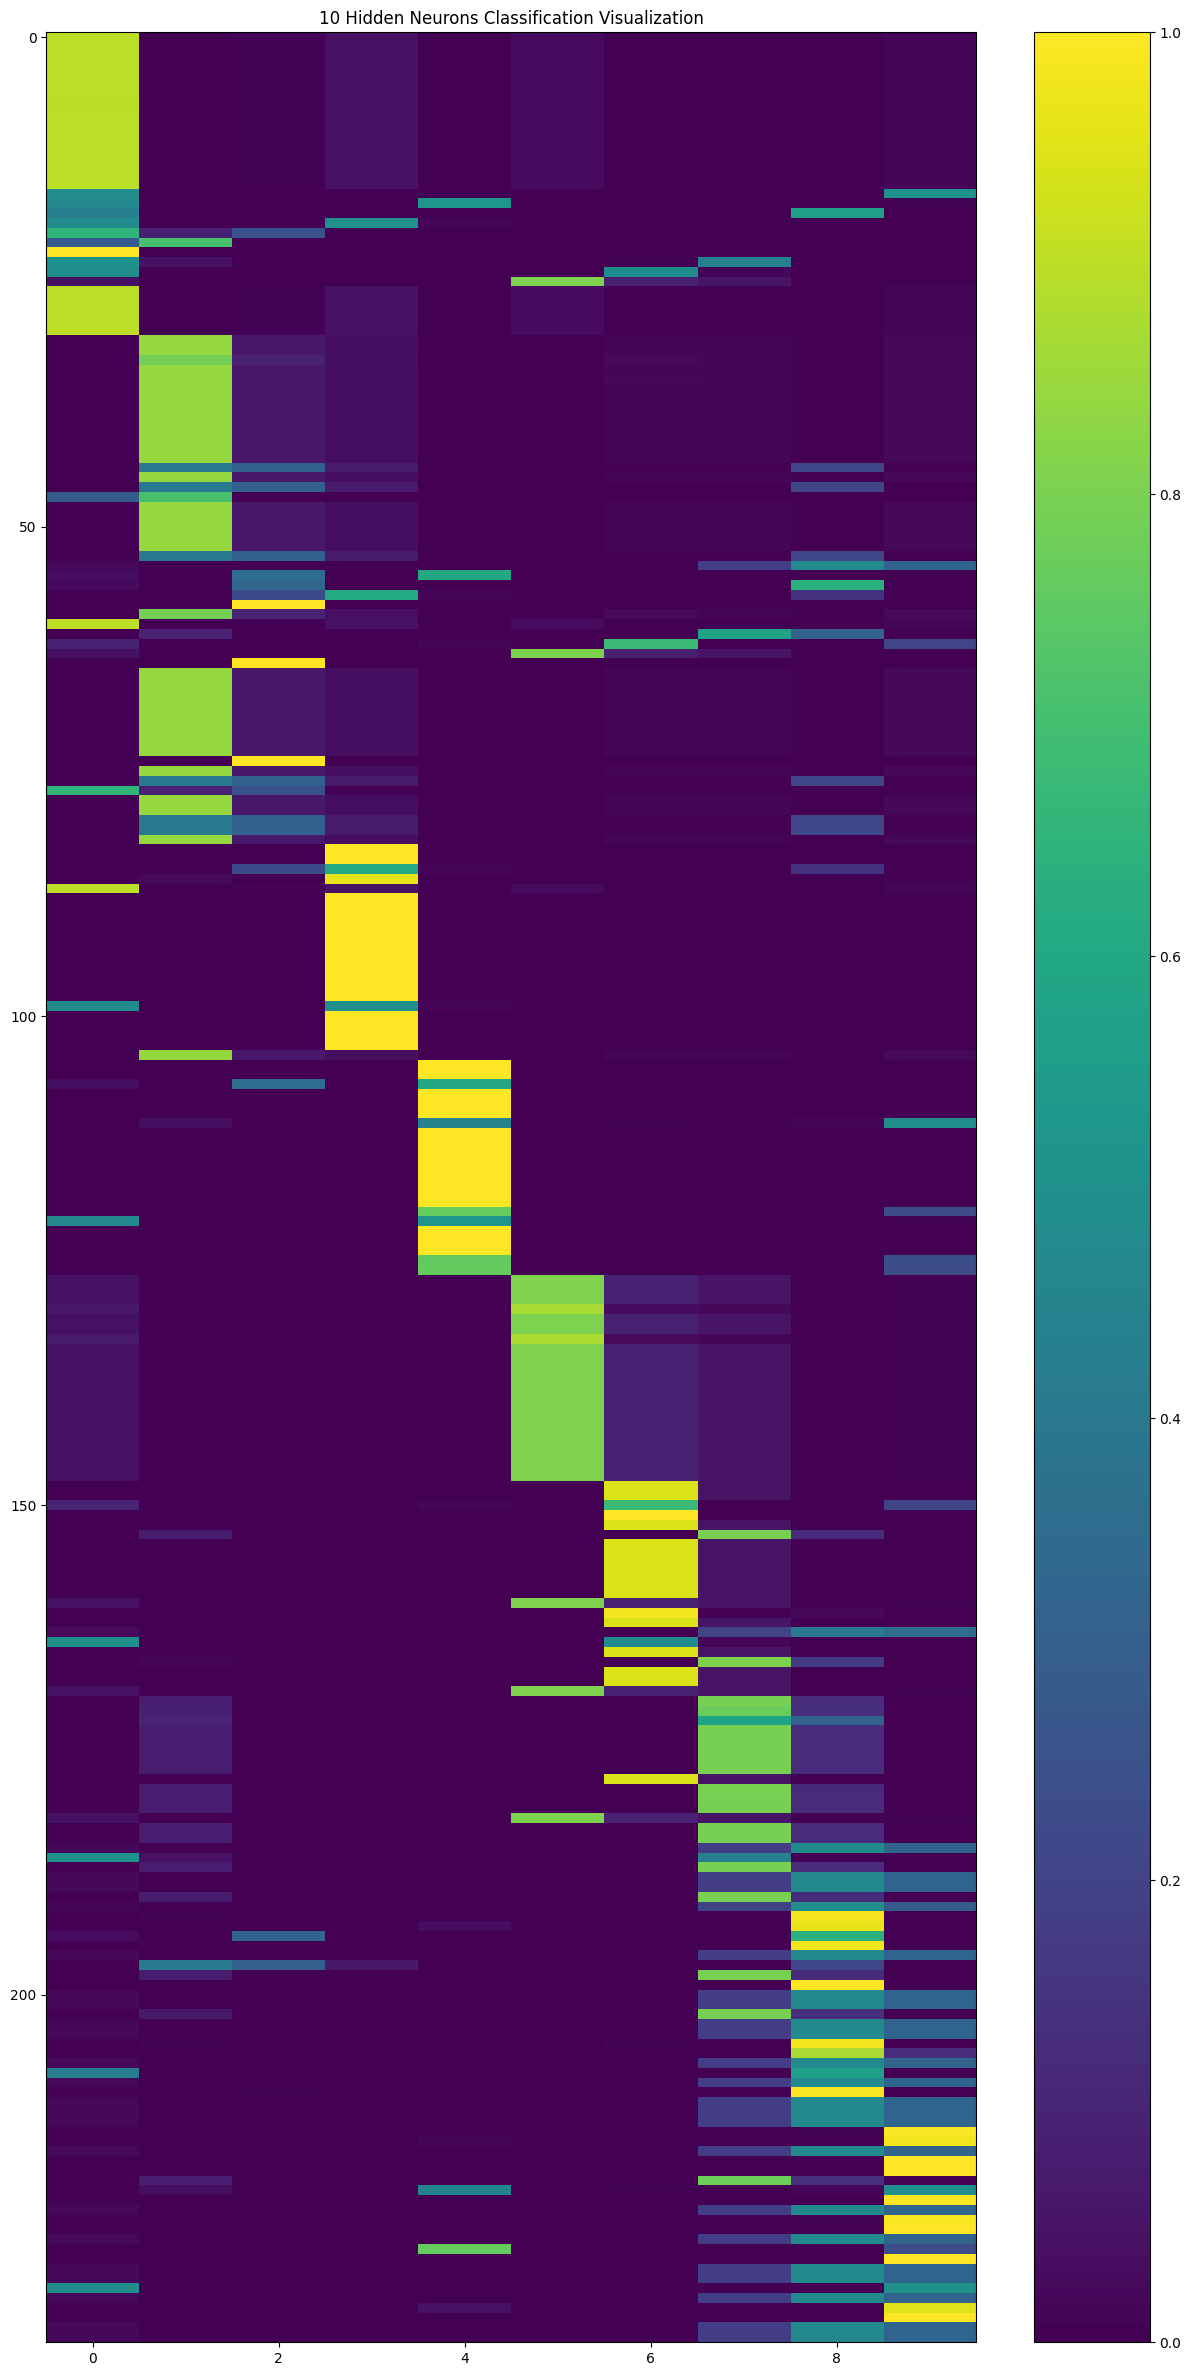

In [59]:
prediction = the_last_model(training_inputs)
plt.imshow(prediction.detach().numpy(), aspect='auto')
plt.title(f"10 Hidden Neurons Classification Visualization")
plt.colorbar()

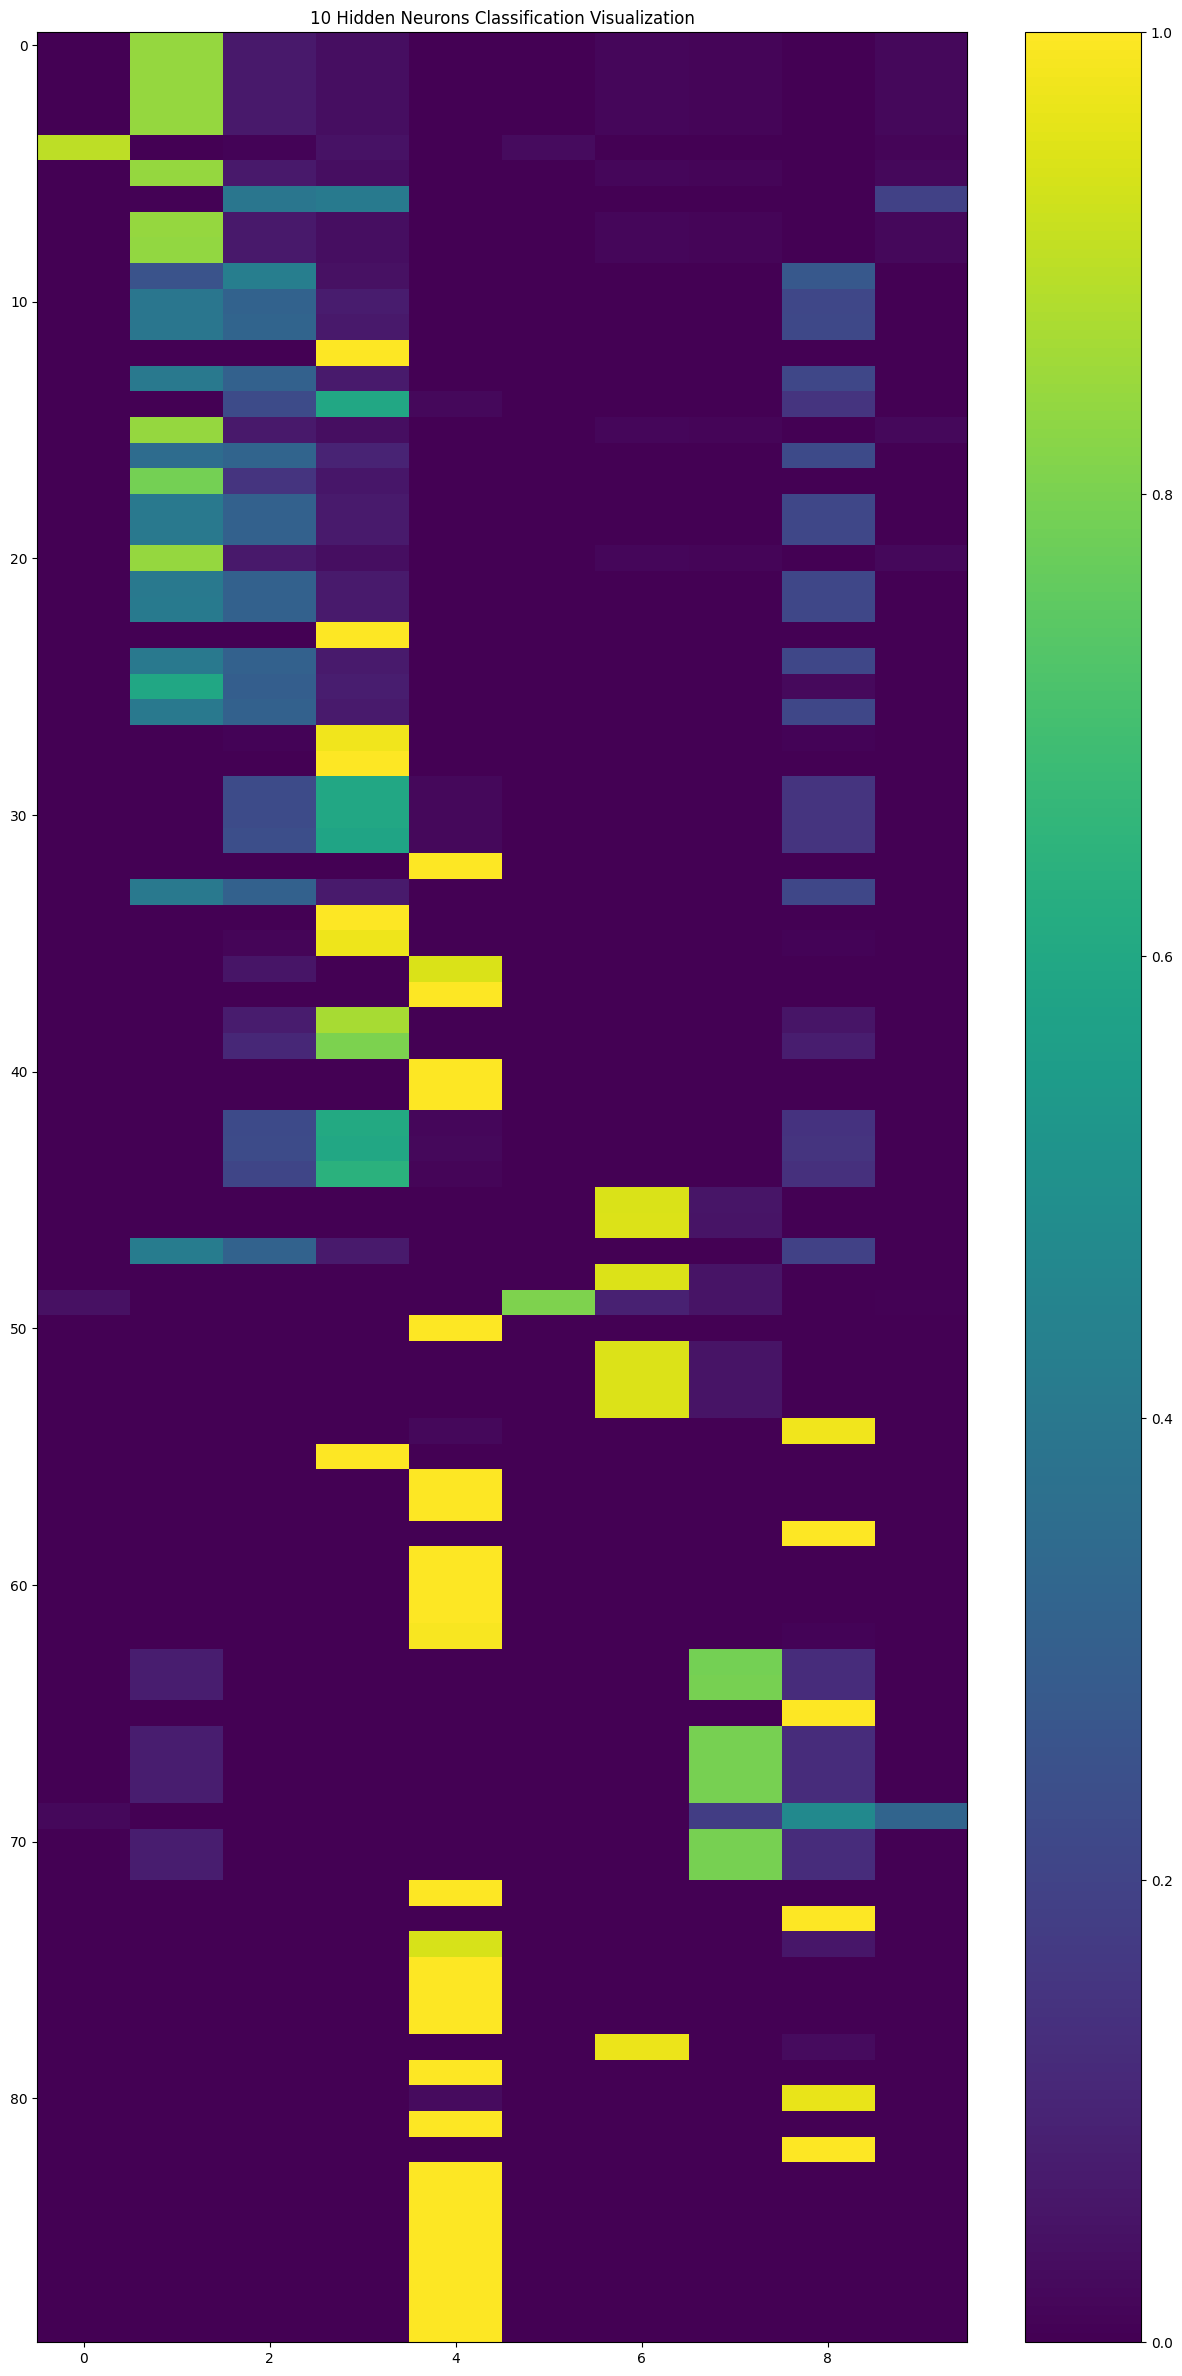

In [60]:
test_inputs, test_labels = testing_data['boy']
prediction = the_last_model(test_inputs)
plt.imshow(prediction.detach().numpy(), aspect='auto')
plt.title(f"10 Hidden Neurons Classification Visualization")
plt.colorbar()